### Library Imports

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from torch import nn
from torch.utils.data import DataLoader, Dataset
from transformers import AdamW, get_linear_schedule_with_warmup, GPT2ForSequenceClassification, GPT2Tokenizer, BertModel, DistilBertModel, DistilBertTokenizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from google.colab import drive
import warnings

nltk.download('punkt')
nltk.download("punkt_tab")
nltk.download('stopwords')
nltk.download('wordnet')

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
drive.mount("/content/drive")
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Loading the dataset

In [2]:
path = "/content/drive/MyDrive/Colab Notebooks/Lyon1/Dataset/arguments_dataset_cleaned.csv"
df = pd.read_csv(path)
df

,Unnamed: 0,Argument1,Argument2,Relation,cosine_similarity,Language1,Language2
0,0,deductions exemptions eliminated us system inc...,stipend model instead standard deduction provi...,Support,0.084879,en,en
1,1,stipend model instead standard deduction provi...,citizens dont make enough support would enough...,Support,0.181638,en,en
2,2,citizens dont make enough support would enough...,homelessness would longer issue homeless encam...,Support,0.046633,en,en
3,3,stipend model instead standard deduction provi...,stipend system would help people wish seek par...,Support,0.126692,en,en
4,4,stipend model instead standard deduction provi...,stipend system would support lowest end income...,Support,0.129821,en,en
...,...,...,...,...,...,...,...
56972,67187,diet completely lacking carbohydrates unhealthy,zero carb diet consists mostly fatty meat wate...,Support,0.068543,en,en
56973,67188,zero carb diet consists mostly fatty meat wate...,dietary fiber vital maintaining bacteria colon...,Support,0.073980,en,en
56974,67190,zerocarbohydrate diet bad environment indirect...,zero carbohydrate diet produces significantly ...,Support,0.077998,en,en
56975,67191,zerocarbohydrate diet bad environment indirect...,new technologies could alleviate extent damage...,Attack,0.000000,en,en


In [3]:
def lemmatize(text):
    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    lemmatized_text = " ".join(lemmatized_tokens)
    return lemmatized_text

In [4]:
df['Argument1'] = df['Argument1'].apply(lemmatize)
df['Argument2'] = df['Argument2'].apply(lemmatize)

### Model training

In [29]:
# Class for creating the dataset and retrieving embeddings
class ArgumentPairDataset(Dataset):
    def __init__(self, arguments, labels, tokenizer, max_length):
        self.arguments = arguments
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.arguments)

    def __getitem__(self, idx):
        argument = self.arguments[idx]
        label = self.labels[idx]

        # Encode thr arguments
        encoding = self.tokenizer.encode_plus(
            argument,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Classifiers
class BERTClassifier(nn.Module):
    def __init__(self, bert_model_name, num_classes):
        super(BERTClassifier, self).__init__()
        self.bert = DistilBertModel.from_pretrained(bert_model_name)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]
        logits = self.classifier(cls_output)
        return logits

class GPTClassifier(nn.Module):
    def __init__(self, gpt_model_name, num_classes):
        super(GPTClassifier, self).__init__()
        self.gpt = GPT2ForSequenceClassification.from_pretrained(gpt_model_name, num_labels = num_classes)
        self.gpt.config.pad_token_id = self.gpt.config.eos_token_id

    def forward(self, input_ids, attention_mask):
        outputs = self.gpt(input_ids=input_ids, attention_mask=attention_mask)
        return outputs.logits

In [6]:
# Prepare the data
def prepare_data(data):
    texts = [f"""
            Does Argument 2 Attack or Support Argument 1? Your answer must be only one of two words: Attack or Support.
            Argument 1: {row['Argument1']}
            Argument 2: {row['Argument2']}
            Relation:
    """ for row in data]
    labels = [row['Relation'] for row in data]

    le = LabelEncoder()
    encoded_labels = le.fit_transform(labels)

    return texts, encoded_labels, le

In [7]:
def train(model, data_loader, optimizer, device, scheduler=None):
    losses = []
    actual_labels = []
    predictions = []
    model.train()
    criterion = nn.CrossEntropyLoss()
    for batch in data_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        if scheduler is not None:
            scheduler.step()
        predictions.extend(torch.max(outputs, dim=1)[1].cpu().tolist())
        actual_labels.extend(labels.cpu().tolist())
        losses.extend(losses)
    return np.mean(losses), accuracy_score(actual_labels, predictions)

def evaluate(model, data_loader, device):
    model.eval()
    losses = []
    predictions = []
    actual_labels = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            predictions.extend(preds.cpu().tolist())
            actual_labels.extend(labels.cpu().tolist())
    return actual_labels, predictions

#### Testing GPT2

In [ ]:
texts, labels, label_encoder = prepare_data(df.to_dict(orient='records'))
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

In [ ]:
gpt2_model_name ="gpt2"
max_length = 128
batch_size = 16
num_classes = 2
num_epochs = 3

tokenizer = GPT2Tokenizer.from_pretrained(gpt2_model_name)
tokenizer.pad_token = tokenizer.eos_token
train_dataset = ArgumentPairDataset(train_texts, train_labels, tokenizer, max_length)
test_dataset = ArgumentPairDataset(test_texts, test_labels, tokenizer, max_length)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [ ]:
model = GPTClassifier(gpt2_model_name, num_classes).to(device)
optimizer = AdamW(model.parameters(), lr=2e-4)
total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_losses = []
val_losses = []
train_accs = []
val_accs = []
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    train(model, train_dataloader, optimizer, device, scheduler)

Epoch 1/3
Epoch 2/3
Epoch 3/3


Accuracy: 0.6455773955773956


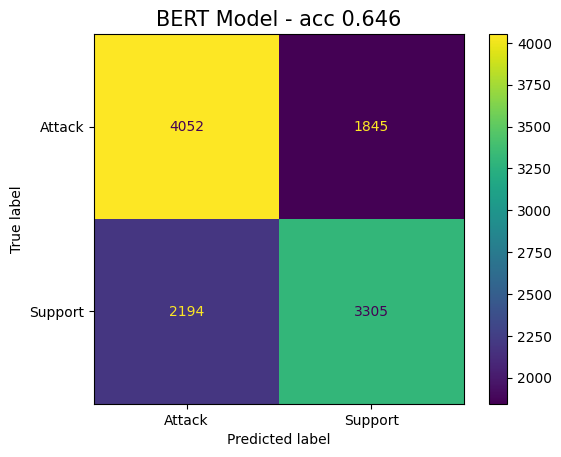

In [ ]:
actual_labels, predictions = evaluate(model, test_dataloader, device)

actual_labels = np.array(actual_labels).reshape((-1,1))
predicted_labels = np.array(predictions).reshape((-1,1))
actual_labels_decoded = label_encoder.inverse_transform(actual_labels)
predictions_decoded = label_encoder.inverse_transform(predicted_labels)

accuracy = accuracy_score(actual_labels, predictions)
print(f"Accuracy: {accuracy}")
ConfusionMatrixDisplay.from_predictions(actual_labels_decoded,predictions_decoded)
plt.title(f'GPT Model - acc {accuracy:.3f}', size=15)
plt.show()

In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/Colab Notebooks/Lyon1/gpt_classifier.pth")

#### Testing BERT

In [30]:
# Prepare the data
def prepare_data(data):
    texts = [f"{row['Argument1']} [SEP] {row['Argument2']}" for row in data]
    labels = [row['Relation'] for row in data]

    le = LabelEncoder()
    encoded_labels = le.fit_transform(labels)

    return texts, encoded_labels, le

In [31]:
texts, labels, label_encoder = prepare_data(df.to_dict(orient='records'))
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

In [32]:
bert_model_name = 'distilbert-base-uncased'
max_length = 128
batch_size = 16
num_classes = 2
num_epochs = 3

tokenizer = DistilBertTokenizer.from_pretrained(bert_model_name)
train_dataset = ArgumentPairDataset(train_texts, train_labels, tokenizer, max_length)
test_dataset = ArgumentPairDataset(test_texts, test_labels, tokenizer, max_length)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

In [33]:
model = BERTClassifier(bert_model_name, num_classes).to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

In [34]:
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    train_loss, train_acc = train(model, train_dataloader, optimizer, device, scheduler)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

Epoch 1/3
Epoch 2/3
Epoch 3/3


Accuracy: 0.6604071604071604


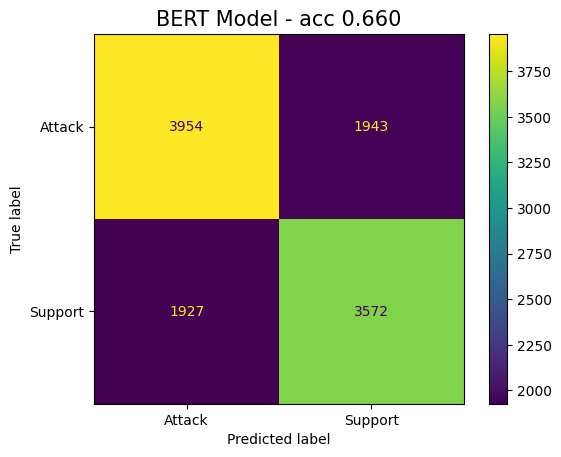

In [35]:
actual_labels, predictions = evaluate(model, test_dataloader, device)

actual_labels = np.array(actual_labels).reshape((-1,1))
predicted_labels = np.array(predictions).reshape((-1,1))
actual_labels_decoded = label_encoder.inverse_transform(actual_labels)
predictions_decoded = label_encoder.inverse_transform(predicted_labels)

accuracy = accuracy_score(actual_labels, predictions)
print(f"Accuracy: {accuracy}")
ConfusionMatrixDisplay.from_predictions(actual_labels_decoded,predictions_decoded)
plt.title(f'BERT Model - acc {accuracy:.3f}', size=15)
plt.show()

In [36]:
torch.save(model.state_dict(), "/content/drive/MyDrive/Colab Notebooks/Lyon1/bert_classifier.pth")